In [3]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from scipy.integrate import quad,dblquad
from scipy.optimize import root_scalar
#import multiprocessing as mp
import vegas

In [4]:
import warnings
# Define my own warning
class OutOfBoundWarning(UserWarning):
    pass

In [5]:
# Useful constant
# 1/MeV^2 to cm^2
to_cm2 = (1.973e-11)**2
# electron mass in MeV
me = 0.511
# tau mass in MeV
mtau = 1776.86
# mu mass in MeV
mmu = 105.658
# gram to MeV
g2MeV = 1/(1.783e-27)

In [54]:
def scatteringAmplitudeSquared(s,t,m1,m2,mV):
    """
    The spin-averaged amplitude squared for vector interaction
    
    Input
    ------
    s: Mandelstam variables s
    t: Mandelstam variables t
    m1: incoming mass
    m2: mass of the particle to be scattered off, at rest in the beginning 
    mV: mediator mass
    
    Output
    ------
    scalar: spin-averaged amplitude squared, dimensionless
    """
    # Define sum over mass squared and u channel
    massSum = m1**2 + m2**2
    u = 2*massSum - s - t
    
    # Spin-averaged amplitude-squared
    ampSquared = 2/(t - mV**2)**2*(s**2+u**2+4*t*massSum-2*massSum**2)
    return ampSquared


def getBDMp(Tx,mx):
    """
    Get the BDM momentum, please do check if the inputs meet the
    physical requirements
    
    Input
    ------
    Tx: BDM kinetic energy
    mx: DM mass
    
    Output
    ------
    px: the BDM momentum
    """
    return np.sqrt(Tx*(Tx + 2*mx))


def getCosPhi(Ev,Tx,mx,psi):
    """
    Get the cos(phi) where phi is the neutrino scattering angle,
    please do check if the inputs meet the physical requirements
    
    Input
    ------
    Ev: the initial neutrino energy
    Tx: the BDM kinetic energy
    mx: the DM mass
    psi: the DM scattering angle
    
    Output
    ------
    cos(phi): the cosine value of the neutrino scattering phi
    """
    return 1/np.sqrt(1 + np.sin(psi)**2/(Ev/getBDMp(Tx,mx) - np.cos(psi))**2)


def getEv_prime(Ev,Tx,mx,psi):
    """
    Neutrino energy after scattering, Ev_prime, please do check if the
    inputs meet the physical requirements
    """
    return Ev*mx/(mx + Ev*(1 - getCosPhi(Ev,Tx,mx,psi)))


def getEvCosPhi(Tx,mx,psi,max_Ev = 1000):
    """
    Get the initial neutrino energy and scattering angle cos(phi) for
    a given (Tx,mx,psi). Additional \'flag\' and \'msg\' will be output
    to indicate the set of solution is valid or not
    
    Input
    ------
    Tx: BDM kinetic energy
    mx: DM mass
    psi: the DM scattering angle, according to the scheme, it should
    be negative (below the horizon)
    max_Ev: Maximum Ev to be searched for the solution of the algorithm
    
    Output
    ------
    tuple
    Ev: Required initial neutrino energy
    cos(phi): the cosine value of the neutrino scattering
    flag: \'valid\' or \'invalid\' for the solution
    msg: 1: Pass, if flag returns \'valid\'
         2: Solution exists but might not be physical because energy-
            momentum conservation is violated. Such violation could be
            due to round-off error. Further check is necessary
         3: The algorithm cannot find the solution for Ev for the given
            \'max_Ev\'.
    """
    # Equation for getting Tx
    def _Tx(Ev):
        return Ev - getEv_prime(Ev,Tx,mx,psi)
    # Target function for root_scalar to find Ev -> Ev_prime - Ev = Tx
    def _f(Ev):
        return _Tx(Ev) - Tx
    # Try to solve the Ev with root_scalar
    try:
        Ev = root_scalar(_f, bracket = [0, max_Ev], method = 'brentq').root
        # Get phi via arccos instead of arctan to aviod minus phi 
        cosPhi = getCosPhi(Ev,Tx,mx,psi)
        # Check the energy-momentum conservation
        if np.sqrt(1 - cosPhi**2)/cosPhi >= 0:
            # pass!
            flag = 'valid'
            msg = 1
        else:
            # solution exists but energy-momentum conservation is violated
            flag = 'invalid'
            msg = 2
    except:
        # root_scalar cannot find Ev in the given range
        Ev = np.nan
        cosPhi = np.nan
        flag = 'invalid'
        msg = 3

    return Ev,cosPhi,flag,msg


def diffCrossSectionNuDM(psi,Tx,mx,mV,gV,gD,max_Ev = 2000):
    """
    Lab-frame differential cross section for neutrino-DM scattering
    
    Input
    ------
    psi: the DM scattering angle in rad
    Tx: the BDM kinetic energy in MeV
    mx: DM mass in MeV
    mV: mediator mass in MeV
    gV: the nu-DM coupling constant
    gD: the DM-DM coupling constant
    max_Ev: maximum Ev to be searched for the solution of the algorithm
    
    Output
    ------
    nu-DM diff. cross section: Lab-frame with unit 1/cm^2 * 1/rad
    """
    # Get the corresponding Ev and cos(phi)
    Ev,cosPhi,flag,msg = getEvCosPhi(Tx,mx,psi,max_Ev = max_Ev)
    
    # Check if the inputs are physical
    if msg == 1:
        # The inputs resulted physical consequence
        
        # Get the neutrino energy after scattering
        Ev_prime = getEv_prime(Ev,Tx,mx,psi)
        
        # The Mandelstam variables
        s = 2*Ev*mx + mx**2
        t = -2*Ev*Ev_prime*(1 - cosPhi)
        
        # The scattering amplitude squared
        amp = scatteringAmplitudeSquared(s,t,0,mx,mV)
        
        # The lab-frame differential cross section
        diffCrox = (1/32/np.pi)/(mx + Ev*(1 - cosPhi))**2*amp*(gV*gD)**2*to_cm2
        return diffCrox
    elif msg == 2:
        # Enery-momentum conservation is violated, the corresponding cross section should be zero
        return 0
    else:
        # Ev cannot be found due to the solution might be outside the max_Ev
        # Try to increase it
        warnings.warn(f'Ev might be outsdie max_Ev = {max_Ev}, try to increase the value and do again',OutOfBoundWarning)
        return 0

def diffCrossSectionElectronDM(s,t,mx,mV):
    """
    Frame-independent differential cross section for DM-electron scattering
    
    Input
    ------
    s: Mandelstam variables s
    t: Mandelstam variables t
    mx: the DM mass in MeV
    mV: mediator mass in MeV
    
    Output
    ------
    DM-e diff. cross section: Frame-independent differential cross section  with unit 1/MeV^3
    """
    pStarSquared = (s - (me + mx)**2)*(s - (me - mx)**2)/4
    # the amplitude squared
    amp = scatteringAmplitudeSquared(s,t,mx,me,mV)
    diffCrox = amp/(64*np.pi*pStarSquared)
    return diffCrox


def KallenLambda(x,y,z):
    """
    The Kallen lambda function
    """
    return x**2 + y**2 + z**2 - 2*(x*y + y*z + z*x)


def get_tpm(m1,m2,s):
    """
    Get the integration range for frame-independent cross section
    
    Input
    ------
    m1: the particle that is going to scatter
    m2: the particle that is going to be scattered off
    s: the s-channel
    
    Output
    ------
    tuple: the allowd range for t: (t_max,t_min)
    """
    E_star2 = (s + m1**2 - m2**2)**2/4/s
    p_star2 = KallenLambda(s,m1**2,m2**2)/4/s
    tp = 2*m1**2 -2*E_star2 + 2*p_star2
    tm = 2*m1**2 -2*E_star2 - 2*p_star2
    return tp,tm


def totalCrossSectionElectronDM(Tx,mx,mV,eps,gD):
    """
    The total cross section for DM-electron scattering in the detector
    
    Input
    ------
    Tx: The DM kinetic energy after boost, MeV
    mx: DM mass, MeV
    mV: mediator mass, MeV
    B: [bV,bA], coefficients for vector and axial-vector interactions at vertex
        Gamma. B = [1,0] indicates vector interaction only
    C: [cV,cA], coefficients for vector and axial-vector interactions at vertex
        Gamma_prime. C = [1,0] indicates vector interaction only
    
    Output
    ------
    DM-e cross section: cm^2
    """
    # DM total energy
    Ex = Tx + mx  
    s = mx**2 + me**2 + 2*Ex*me
    # Integration range for t channel
    tp,tm = get_tpm(mx,me,s)
    # e^2 in terms of the fine structure constant
    e2 = 4*np.pi/137
    
    # Evaluating cross section
    dsdt = lambda t: diffCrossSectionElectronDM(s,t,mx,mV)*to_cm2*(eps*gD)**2*e2
    totCrox,_ = quad(dsdt,tm,tp)
    return totCrox



In [60]:
Tx = 1
mx_ls = np.logspace(-5,1,50)
gV = 1
gD = 1
eps = 1
psi_ls = np.logspace(-2,np.log10(np.pi),20)
sigxv_quad = []
sigxv_vegas = []
integ = vegas.Integrator([[0, np.pi]])
for mx in mx_ls:
    def f(psi):
        return diffCrossSectionNuDM(psi,Tx,mx,mx/3,gV,gD,max_Ev = 100)
    result = integ(f, nitn=10, neval=5000)
    try:
        sigxv_vegas.append(result[0].mean)
    except:
        sigxv_vegas.append(result.mean)
    
    sigxv_quad.append(quad(lambda psi: diffCrossSectionNuDM(psi,Tx,mx,mx/3,gV,gD,max_Ev=100),0,np.pi)[0])

/var/folders/hn/1jz0yfh126gfjftdf5gl55fm0000gn/T/ipykernel_75857/1200540183.py:171: OutOfBoundWarning: Ev might be outsdie max_Ev = 100, try to increase the value and do again
  warnings.warn(f'Ev might be outsdie max_Ev = {max_Ev}, try to increase the value and do again',OutOfBoundWarning)


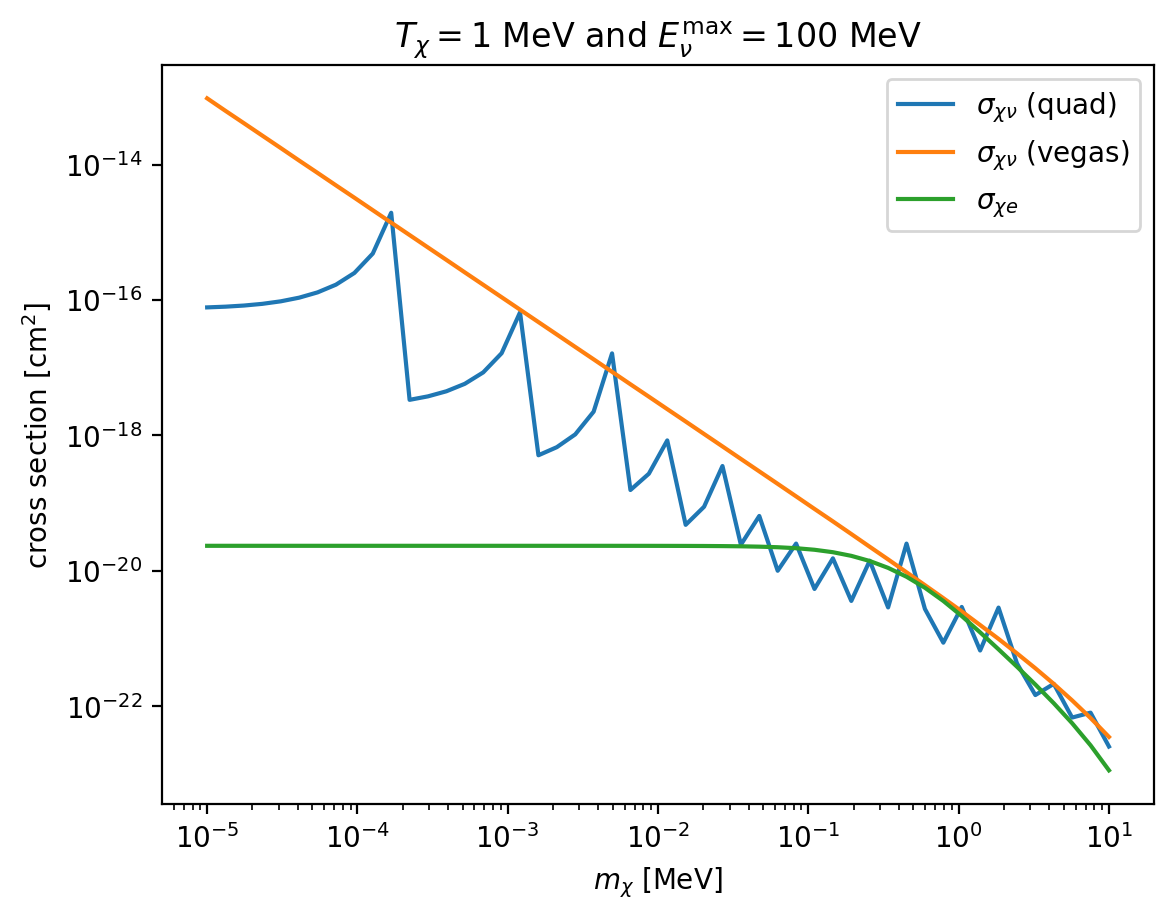

In [67]:
plt.plot(mx_ls,sigxv_quad,label=r'$\sigma_{\chi\nu}$ (quad)')
plt.plot(mx_ls,sigxv_vegas,label=r'$\sigma_{\chi\nu}$ (vegas)')
plt.plot(mx_ls,sigxe,label=r'$\sigma_{\chi e}$')
plt.legend()
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'cross section [cm$^2$]')
plt.title(r'$T_\chi =1$ MeV and $E_\nu^{\rm max}=100$ MeV')
plt.xscale('log')
plt.yscale('log')
plt.savefig('cross_section.pdf',bbox_inches='tight')

In [56]:
def f(psi):
    return diffCrossSectionNuDM(psi,Tx,0.01,0.01/3,gV,gD,max_Ev = 100)
integ = vegas.Integrator([[0, np.pi]])
result = integ(f, nitn=10, neval=5000)

/var/folders/hn/1jz0yfh126gfjftdf5gl55fm0000gn/T/ipykernel_75857/1200540183.py:171: OutOfBoundWarning: Ev might be outsdie max_Ev = 100, try to increase the value and do again
  warnings.warn(f'Ev might be outsdie max_Ev = {max_Ev}, try to increase the value and do again',OutOfBoundWarning)


In [59]:
result[0].mean

2.9942181598305995e-18

In [62]:
Tx = 1
mx_ls = np.logspace(-5,1,50)
gV = 1
gD = 1
eps = 1
psi_ls = np.logspace(-2,np.log10(np.pi),100)
sigxe = []
sigxv = []
for mx in mx_ls:
    sigxe.append(quad(lambda Tx: totalCrossSectionElectronDM(Tx,mx,mx/3,eps,gD),5,100)[0])
    #sigxv.append(quad(lambda psi: diffCrossSectionNuDM(psi,Tx,mx,mx/3,gV,gD,max_Ev=100),0,np.pi)[0])
    #sigxv_newton.append(diffCrossSectionNuDM(psi,Tx,mx,mx/3,gV,gD,method='newton')

#sigxv_psi_mx1keV = []
#sigxv_psi_mx30keV = []
#for psi in np.logspace(-9,np.log10(np.pi),1000):
#    sigxv_psi_mx1keV.append(diffCrossSectionNuDM(psi,Tx,0.001,0.001/3,gV,gD))
#    sigxv_psi_mx30keV.append(diffCrossSectionNuDM(psi,Tx,0.030,0.030/3,gV,gD))

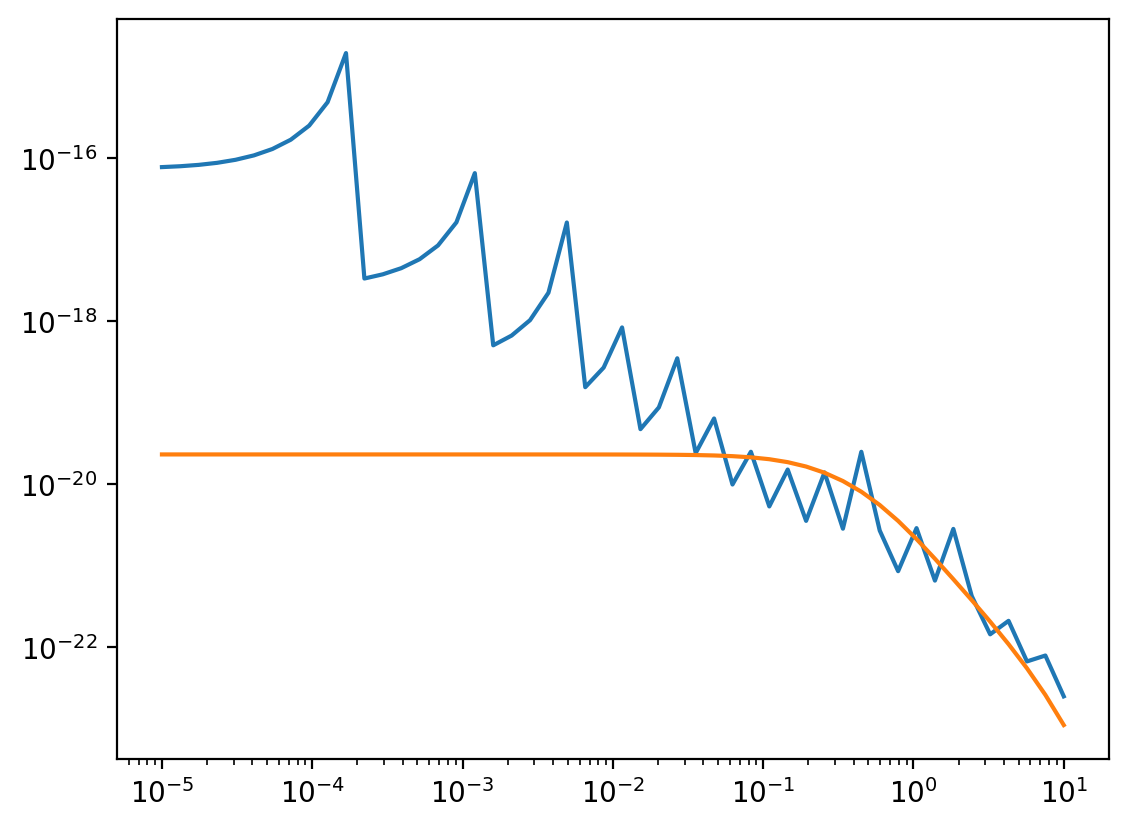

In [31]:
plt.plot(mx_ls,np.asarray(sigxv))
plt.plot(mx_ls,np.asarray(sigxe))
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-27,3e-26)

In [73]:
dblquad(lambda y,x: np.sin(x)*np.sin(y),-1,2,np.pi,0)

(-1.9128982848305638, 4.168206170141087e-14)

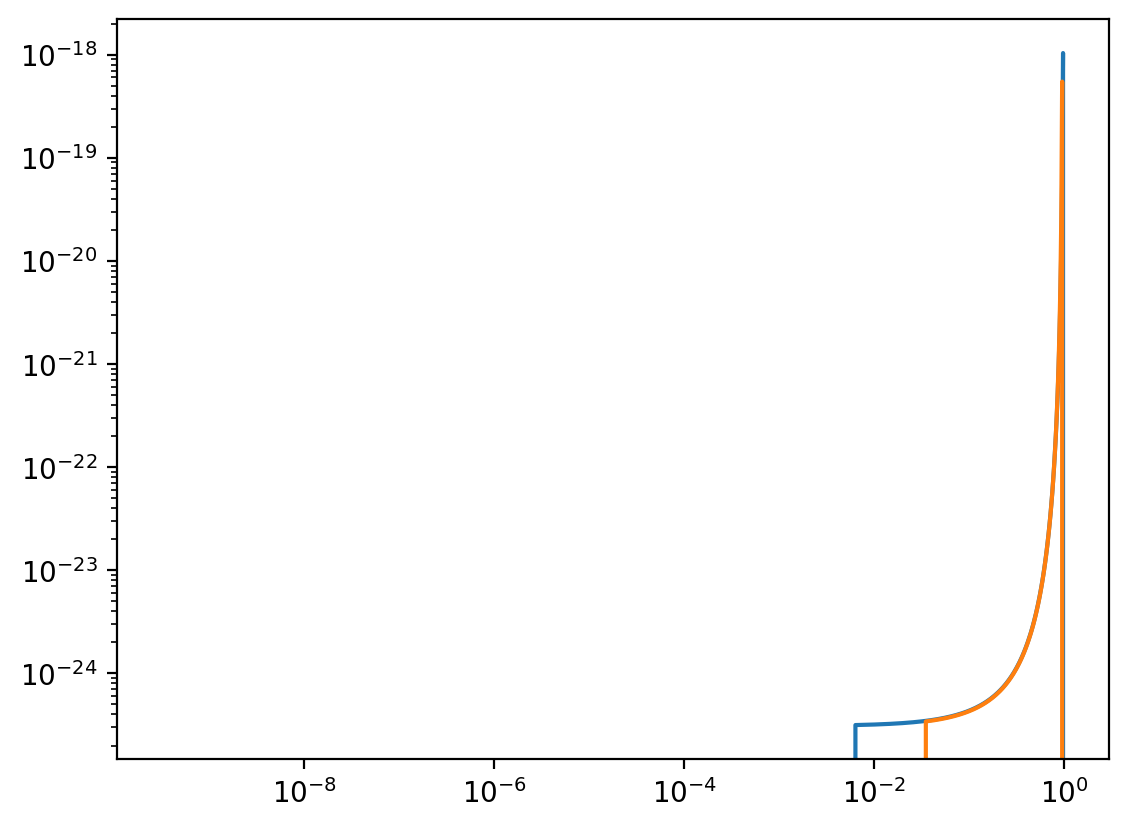

In [55]:
plt.plot(np.logspace(-9,np.log10(np.pi),1000)/np.pi,sigxv_psi_mx1keV)
plt.plot(np.logspace(-9,np.log10(np.pi),1000)/np.pi,sigxv_psi_mx30keV)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-27,3e-26)

In [14]:
# Kinetic mixing from mu/tau loops, only important when the direct mixing \epsilon = 0
def eps_prime(gV,q):
    """
    Get the epsilon induced by mu/tau loops
    
    Input
    ------
    gV: the DM-lepton coupling constant
    q: the momentum transfer, in MeV
    
    Output
    ------
    scalar: the epsilon
    """
    # electric charge
    e = np.sqrt(4*np.pi/137)
    
    # Define q^2. In this t-channel, q^2 is always spacelike
    q2 = -q**2
    # define the integrand
    integ = lambda x: x*(1-x)*np.log((mtau**2-x*(1-x)*q2)/(mmu**2-x*(1-x)*q2))*e*gV/2/np.pi**2
    # evaluate epsilon
    eps_p,_ = quad(integ,0,1)
    return -eps_p


def diff_sig_xnu(Tx,mx,mV,psi,gV,gD,max_Ef=1000):
    """
    Differential cross section for SNnu-DM scattering at scattering angle psi for DM
    
    Input
    ------
    Ev: The initial SN neutrino energy, MeV
    Tx: The DM kinetic energy after boost, MeV
    mx: DM mass, MeV
    mV: mediator mass, MeV
    psi: The DM scattering angle after boost, rad
    gV: the DM-nu coupling constant
    gD: the DM-DM coupling constant
    max_Ef: Upper limit for the root finding algortihm to find the solution.
            Try to increase if get_Ef_phi returns error
    
    Output
    ------
    scalar: cm^2
    """
    # Get the associated initial nu energy and its scattering angle phi
    Ev,phi,flag,_ = get_Ef_phi(Tx,mx,psi,max_Ef)
    
    # Calculating the DM-nu cross section at angle psi and converts it into cm^2
    if flag == 'valid':
        crox = (gV*gD)**2*diff_sig_lab(Ev,mx,mV,phi)*to_cm2
    elif flag == 'invalid': # if it is invalid, the inputs cannot happen
        crox = 0
    return crox


def sig_xe(Tx,mx,mV,eps,gD):
    """
    The total cross section for DM-electron scattering in the detector
    
    Input
    ------
    Tx: The DM kinetic energy after boost, MeV
    mx: DM mass, MeV
    mV: mediator mass, MeV
    B: [bV,bA], coefficients for vector and axial-vector interactions at vertex
        Gamma. B = [1,0] indicates vector interaction only
    C: [cV,cA], coefficients for vector and axial-vector interactions at vertex
        Gamma_prime. C = [1,0] indicates vector interaction only
    
    Output
    ------
    scalar: cm^2
    """
    Ex = Tx+mx    # The DM total energy
    s = mx**2+me**2+2*Ex*me    # The s channel
    tp,tm = get_tpm(mx,me,s)    # The allowed range for t channel
    e2 = 4*np.pi/137    # e^2 in terms of fine structure constant
    
    # evaluate cross section
    dsdt = lambda t: diff_sig_fi(s,t,mx,me,mV)*to_cm2*(eps*gD)**2*e2
    crox,_ = quad(dsdt,tm,tp)
    
    return crox

In [16]:
sig_xe(50,1,1/3,1,1)

3.574988727822382e-24

In [42]:
sig_xe(50,1,1/3,1,1)

3.574988727822382e-24

In [43]:
get_tpm(10,me,10**2+me**2+2*(50+10)*me)

(-50.13056050000003, -72.75507243168784)

In [31]:
get_tpm(1,me,1**2+me**2+2*(50+1)*me)

(-0.6305605000000014, -51.5016663688382)

In [44]:
tlist = np.linspace(-72.75507243168784, -50.13056050000003,50)

In [45]:
siglist = []
for t in tlist:
    s = 10**2+me**2+2*(50+10)*me
    siglist.append(diff_sig_fi(s,t,10,me,10/3))

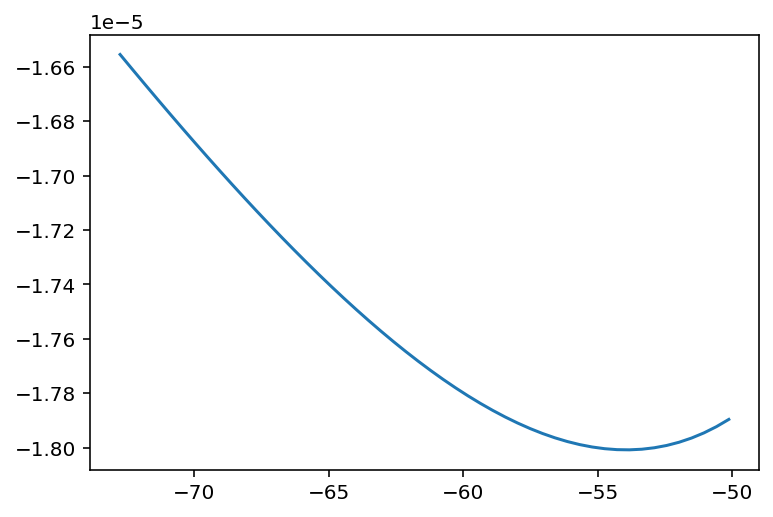

In [46]:
plt.plot(tlist,siglist)

In [29]:
get_tpm(me,10,10**2+me**2+2*(50+10)*me)

(-50.130560499999994, -72.75507243168788)

In [57]:
get_tpm(10,me,10**2+me**2+2*(50+10)*me)

(-1.0658141036401503e-14, -22.624511931687824)

In [36]:
s=10**2+me**2+2*(50+10)*me

In [37]:
(s-(10+me)**2)*(s-(10-me)**2)

3655.6939999999995

In [51]:
def sig_xnu_bar(Ev_range,mx,mV,gV,gD):
    # Energy range of interest
    Ev_min,Ev_max = Ev_range
    
    # Frame-independent cross section
    def _sig_xnu(Ev):
        s = 2*Ev*mx + mx**2
        tp,tm = get_tpm(0,mx,s)
        crox,_ = quad(lambda t: diff_sig_fi(s,t,0,mx,mV)*to_cm2,tm,tp)
        return crox
    
    # Evaluate energy-average cross section
    avg_crox,_ = quad(_sig_xnu,Ev_min,Ev_max)
    # Including coupling constants
    avg_crox = avg_crox*(gV*gD)**2/(4*np.pi)/(Ev_max-Ev_min)
    return avg_crox


def sig_xe_bar(Tx_range,mx,mV,eps,gD):
    
    # Get the Txmin and Txmax
    Tx_min,Tx_max = Tx_range
    
    #sig_xe(Tx,mx,mV,B,C,eps,gD)
    _sig_xe = lambda Tx: sig_xe(Tx,mx,mV,eps,gD)#sig_xe_vector(Tx,mx,mV,eps,gD)
    
    avg_crox,_ = quad(_sig_xe,Tx_min,Tx_max)
    avg_crox = avg_crox/(Tx_max-Tx_min)
    return avg_crox


In [66]:
mx_list = np.logspace(-6,1,50)
Tmax_list = np.logspace(-2,4,20)
sig_xnu_list = []
sig_xe_list = []
for mx in mx_list:
    sig_xnu_list.append(sig_xnu_bar([0.5,100],mx,mx/3,1,1))
    sig_xe_list.append(sig_xe_bar([0.5,100],mx,mx/3,1,1))
sig_xnu_list = np.array(sig_xnu_list)
sig_xe_list = np.array(sig_xe_list)

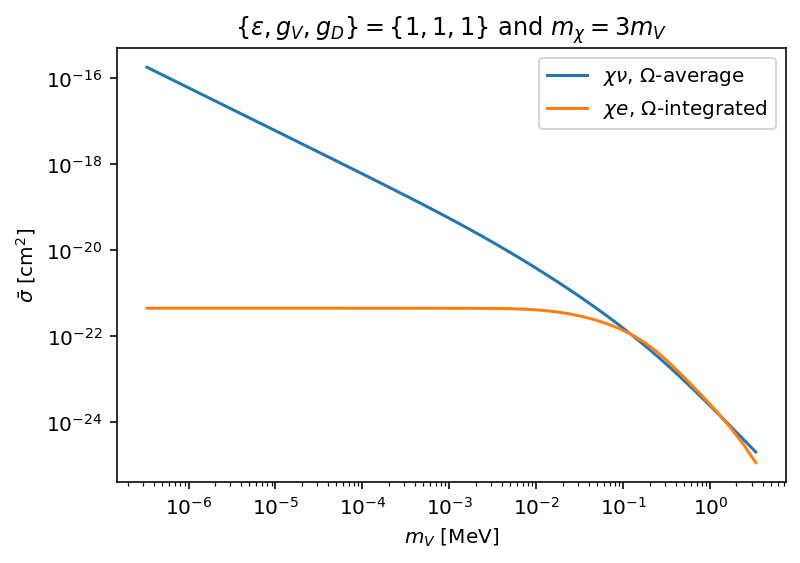

In [67]:
plt.plot(mx_list/3,sig_xnu_list,label=r'$\chi\nu$, $\Omega$-average')
plt.plot(mx_list/3,sig_xe_list,label='$\chi e$, $\Omega$-integrated')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-27,1e-15)
plt.xlabel(r'$m_V$ [MeV]')
plt.ylabel(r'$\bar{\sigma}~[{\rm cm}^2]$')
plt.title(r'$\{\varepsilon,g_V,g_D\}=\{1,1,1\}~{\rm and}~m_\chi=3m_V$')
plt.legend()
#plt.savefig('../plots/cross_section_lighter_mV.pdf',bbox_inches='tight')
plt.show()

In [65]:
sig_xnu_list

array([1.80271376e-16, 1.18098750e-16, 7.73676882e-17, 5.06836065e-17,
       3.32021031e-17, 2.17494717e-17, 1.42465271e-17, 9.33113560e-18,
       6.11092502e-18, 4.00127730e-18, 2.61919320e-18, 1.71376011e-18,
       1.12059963e-18, 7.32025196e-19, 4.77491702e-19, 3.10787744e-19,
       2.01645007e-19, 1.30240976e-19, 8.35961986e-20, 5.32114061e-20,
       3.35158258e-20, 2.08477667e-20, 1.27877064e-20, 7.72801813e-21,
       4.59899061e-21, 2.69306117e-21, 1.54963232e-21, 8.74288753e-22,
       4.82140165e-22, 2.58863267e-22, 1.34707506e-22, 6.76406574e-23,
       3.26655440e-23, 1.51625428e-23, 6.78787435e-24, 2.95255534e-24,
       1.25934906e-24, 5.30566575e-25, 2.21436813e-25, 9.14435217e-26,
       3.72189744e-26, 1.48447137e-26, 5.75569646e-27, 2.14560516e-27,
       7.57703721e-28, 2.48812412e-28, 7.44500480e-29, 1.99796760e-29,
       4.79777541e-30, 1.04735291e-30])